# Deep Recurrent Neural Networks

Up until now, we have focused on defining networks consisting of a sequence input, a single hidden RNN layer, and an output layer. Despite having just one hidden layer between the input at any time step and the corresponding output, there is a sense in which these networks are deep. Inputs from the first time step can influence the outputs at the final time step  (often 100s or 1000s of steps later). These inputs pass through applications of the recurrent layer before reaching the final output. However, we often also wish to retain the ability to express complex relationships between the inputs at a given time step and the outputs at that same time step. Thus we often construct RNNs that are deep not only in the time direction but also in the input-to-output direction. This is precisely the notion of depth that we have already encountered in our development of MLPs and deep CNNs.

The standard method for building this sort of deep RNN is strikingly simple: we stack the RNNs on top of each other. Given a sequence of length _T_, the first RNN produces a sequence of outputs, also of length _T_. These, in turn, constitute the inputs to the next RNN layer. 

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Implementation from scratch

In [2]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(*[d2l.RNNScratch(
            num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
                                    for i in range(num_layers)])

__Forward Method:__

In [3]:
@d2l.add_to_class(StackedRNNScratch)
def forward(self, inputs, Hs=None):
    outputs = inputs
    if Hs is None: Hs = [None] * self.num_layers
    for i in range(self.num_layers):
        outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
        outputs = torch.stack(outputs, 0)
    return outputs, Hs

## Training

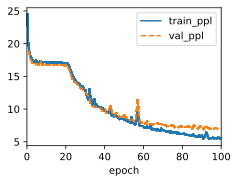

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab),
                              num_hiddens=32, num_layers=2)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### Concise implementation

In [5]:
class GRU(d2l.RNN):  #@save
    """The multi-layer GRU model."""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)

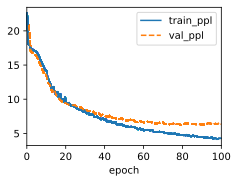

In [6]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

### Prediction

In [7]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has a moment of space a'

In deep RNNs, the hidden state information is passed to the next time step of the current layer and the current time step of the next layer. There exist many different flavors of deep RNNs, such as LSTMs, GRUs, or vanilla RNNs. Conveniently, these models are all available as parts of the high-level APIs of deep learning frameworks. Initialization of models requires care. Overall, deep RNNs require considerable amount of work (such as learning rate and clipping) to ensure proper convergence.